# PyTorch

* PyTorch [website](https://pytorch.org/)
* [Tutorials](https://pytorch.org/tutorials/)`

In [1]:
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
def img_show(img, opencv=False):
    if opencv:
        img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_to_show = img
    plt.figure(dpi=50)
    plt.axis('off')
    plt.imshow(img_to_show)
    plt.show()

## Dataset
### Task: image classification

Dataset: [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) - 10 classes, color images 32x32 px

In [3]:
# CIFAR10 Classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

* Real-world PyTorch dataset [example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
* PyTorch torchvision [datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [4]:
train_split_len = 8192*5
test_split_len = 4096*5

def get_loaders(batch_size=128, num_workers=2, transform=transforms.ToTensor()):
    train = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
    test = datasets.CIFAR10('../data', train=False, download=True, transform=transform)
    torch.manual_seed(123)  # To ensure the same sampling during each experiment
    train = torch.utils.data.random_split(train, [train_split_len, len(train)-train_split_len])[0]
    test = torch.utils.data.random_split(test, [test_split_len, len(test)-test_split_len])[0]
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, test_loader

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Tensor shape: torch.Size([8, 3, 32, 32]) BatchxCxHxW
cat


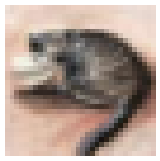

deer


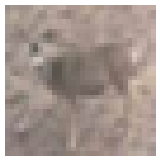

dog


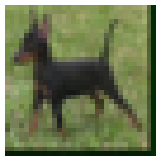

ship


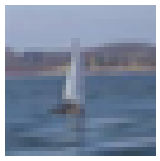

deer


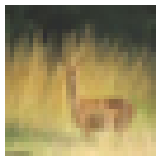

frog


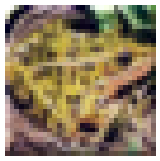

frog


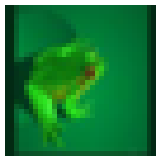

horse


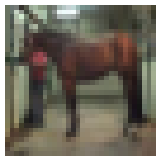

In [5]:
train_loader, test_loader = get_loaders(8)
images, labels = iter(train_loader).next()
print("Tensor shape: {} BatchxCxHxW".format(images.shape))
labels = labels.numpy()
for i in range(images.shape[0]):
    print(classes[labels[i]])
    img = images[i, ...].numpy()
    img = np.moveaxis(img, 0, 2)
    img_show(img)

## Model

Docs:

* [torch.nn](https://pytorch.org/docs/stable/nn.html)
* torchvision [models](https://pytorch.org/docs/stable/torchvision/models.html)


```
conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
pool = nn.MaxPool2d(kernel_size, stride, padding)
batchnorm = nn.BatchNorm2d(num_features)
fc = nn.Linear(in_features, out_features)
dropout = nn.Dropout2d(p)

```

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)  # Batchx16x5x5
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  # Batchx10
        x = F.log_softmax(x, 1)
        return x

In [7]:
def train(model, device, train_loader, optimizer):
    model.train()
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, target)
        loss.backward()
        optimizer.step()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    totnum = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            out = model(data)
            loss = F.nll_loss(out, target, reduction='sum')
            test_loss += loss.item()
            outputAc = torch.argmax(out,dim=1)
            correct += (outputAc == target).float().sum()
            totnum += outputAc.size()[0]

    return test_loss / len(test_loader.dataset), correct/totnum

def EarlyStopping(paramTrain,ParamTest,typeF = 'easy',pStop=[5, 0.1],outF=False):
    FlagOfStopping = False
    if typeF == 'easy':
      param = torch.abs((paramTrain[0]-paramTrain[1])/(ParamTest[0]-ParamTest[1])/pStop[0])
      if outF:
        print('param: {:.3f}'.format(param))
      if param>1:
        FlagOfStopping = True
    elif typeF == 'esdf':
      try:
        param1 = torch.abs((paramTrain[0]-paramTrain[1])/(ParamTest[0]-ParamTest[1])/pStop[0])
        param2 = torch.abs((paramTrain[1]-ParamTest[1])/ParamTest[1]*pStop[1])
      except:
        param1=1
        param2=1
      if outF:
        print('param: {:.3f} param dif: {:.3f}'.format(param1,param2))
      if ((param1>1)or(param2>1)):
        FlagOfStopping = True
    else:
      pass

    return FlagOfStopping

In [8]:
#Check that we have a GPU
torch.cuda.is_available()

True

In [8]:
epochs = 100
device = torch.device('cuda:0')

batch_size = 64
lr = 1e-3

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, test_loader = get_loaders(batch_size=batch_size, transform=transform, num_workers=4)
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=2,verbose=False,eps=1e-10)
acc_train = []
acc_test = []

ls_train = []
ls_test = []

lastTrain = 0
lastTest = 0

for epoch in range(epochs):
    train(model, device, train_loader, optimizer)
    test_loss, acc = test(model, device, test_loader)
    train_loss, acc_tr = test(model, device, train_loader)
    scheduler.step(torch.round(acc*1000))
    acc_train.append(acc_tr)
    acc_test.append(acc)    
    ls_train.append(train_loss)
    ls_test.append(test_loss)
    print("Epoch: {}, test loss: {} \n accuracy test: {:.1f}% accuracy train: {:.1f}% \n".format(epoch, test_loss, 100*acc,100*acc_tr))
    #if EarlyStopping([acc_tr,lastTrain],[acc,lastTest],outF=True):
    #  break
    lastTest = acc
    lastTrain = acc_tr

Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, test loss: 1.4784249017715454 
 accuracy test: 46.0% accuracy train: 46.1% 

Epoch: 1, test loss: 1.3508886516571046 
 accuracy test: 51.3% accuracy train: 52.7% 

Epoch: 2, test loss: 1.2712690359115602 
 accuracy test: 54.9% accuracy train: 56.4% 

Epoch: 3, test loss: 1.2163053276062012 
 accuracy test: 56.8% accuracy train: 59.5% 

Epoch: 4, test loss: 1.172018707370758 
 accuracy test: 58.9% accuracy train: 62.3% 

Epoch: 5, test loss: 1.1331390992164612 
 accuracy test: 59.6% accuracy train: 64.2% 

Epoch: 6, test loss: 1.0973761045455932 
 accuracy test: 61.4% accuracy train: 66.6% 

Epoch: 7, test loss: 1.1143366345405579 
 accuracy test: 60.7% accuracy train: 66.3% 

Epoch: 8, test loss: 1.0788593642234803 
 accuracy test: 62.2% accuracy train: 68.9% 

Epoch: 9, test loss: 1.0701765481948853 
 accuracy test: 62.6% accuracy train: 69.6% 

Epoch: 10, test loss: 1.1039798644065857 
 accuracy tes

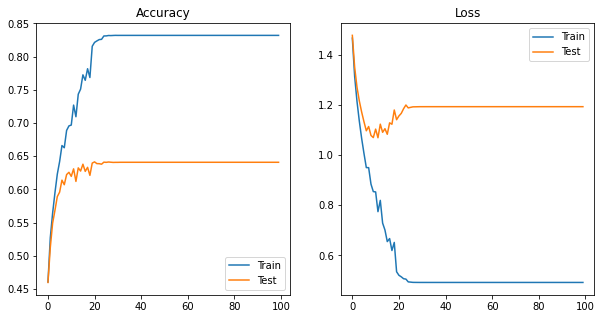

In [9]:
import matplotlib.pyplot as plt
 
dLTrain = np.array(ls_train,dtype='float')
dLTest = np.array(ls_test,dtype='float')

dATrain = np.array(acc_train,dtype='float')
dATest = np.array(acc_test,dtype='float')

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,2,1)
ax.plot(dATrain)
ax.plot(dATest)
ax.legend(['Train','Test'])
ax.set_title('Accuracy')
ax1 = f.add_subplot(1,2,2)
ax1.set_title('Loss')
ax1.plot(dLTrain)
ax1.plot(dLTest)
ax1.legend(['Train','Test'])


## Homework 03

Task: Train a DL model to classify CIFAR10 dataset with accuracy >75%

1. (1) Implement top-1 percentage correct metric (accuracy) and apply it on the test stage.
2. (1) Use ReduceLROnPlateau to monitor the model performance by the accuracy metric on the test subset and adjust learning rate. Use EarlyStopping to avoid overfitting.
4. (3) Experiment to achieve accuracy >75%. Experiments may include: Architecture changes, data augmentation, LR and training strategy changes. Feel free to change any part of the starter code.


Use [leaderboard](https://paperswithcode.com/sota/image-classification-on-cifar-10) for inspiration.

20

4*. (2) achieve accuracy >80%.

5**(8). Achieve accuracy >92%.

6 * * * (100). Achieve accuracy >93.51% on **CIFAR100**.

[leaderboard](https://paperswithcode.com/sota/image-classification-on-cifar-100)

Use any novel or existing model, except for EffNet-L2.

Rules:
1. Do not use extra data, pretrained models.
2. Do not modify labels.
3. Follow [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html) protocol.
3. Deadline is 13/02/2021.